# Log
- optimization averege across different confusion matrices - that seems to have a big effect on the performance of enabling surrogate

# TODO
 - keep the confusion matrix estimation same - across all trials?
 - double check that params are getting properly propagated for the Agent and environment
 - ~~grid search for parameters~~
 - figure out parameters in surrogate rewards
 - ~~make rewards non binary in environment and surrogate rewards~~
 - ~~add deceay from papers, log and other~~
 - ~~initiate q-table at `-1`?~~
 - run experiment with different `correct_action`
 - should we be setting up the glove for `very distinguishable` levels? Shouldn't we set it up with `barely distinguishable` levels, as this is where the perturbed rewards come on - they'd help us get through the noise and find the correct level.

# Imports

In [1]:
import numpy as np
import collections
import pandas as pd
import argparse
import time
import numpy as np

In [2]:
import noise_estimator

In [3]:
from ucbq_agent_stateless import UCBQAgent
from ucbq_environment_stateless import ModifiedRandomEnvironment

# Params

In [9]:
def default_params():
    """ These are the default parameters used in the framework. """
    return {
            # Runner parameterr
            'max_steps': 120,
            'num_episodes': 100,
            'num_actions': 7, 
            'start_action': 0, 
            'correct_action': 1,    # Zero indexed 
            # 'multi_runner': False,            # uses multiple runners if True
            # Optimization parameters
            'alpha': 0.5,                       # learning rate of optimizer
            'alpha_decay': 40,
            'alpha_min': 0.001,
            # Exploration parameters
            'epsilon': 1,               # annealing starts at this epsilon
            'epsilon_decay': 20,
            'epsilon_min': 0.01,    
            'gamma': 0.95,                    # discount factor gamma
            'plots': False,
            'noise': True,
            'surrogate': False,            
           }

# Scripts

In [4]:
import matplotlib.pyplot as plt
from tqdm import tqdm 
import utils

In [5]:
from modified_pendulum_processor import ModifiedPendulumProcessor

In [6]:
def runner(adjust_rewards=None, 
           agent=None,
           env=None,
           params={}):

    agent = UCBQAgent(params=params) if agent is None else agent
    env = env if env else ModifiedRandomEnvironment()

    episode_rewards = 0
    rewards = []
    q_values_for_chart = []
    
    t = 0
    start_action = params.get('start_action', 0)
    action = start_action
    state = 0
    max_steps = params.get('max_steps', 120)
    correct_action = params.get('correct_action', 3)
    plots = params.get('plots', True)
    noise = params.get('noise', False)
    num_actions = params.get('num_actions', 7)
    surrogate = params.get('surrogate', False)
    surrogate_c_interval = params.get('surrogate_c_interval', 10)
    
    reward_processor = None

    # surrogate can only be with noise=True for now
    if surrogate:
        noise = True
    
    if noise: 
        #TODO: should we keep/carry over the estimated confusion matrix across all episodes?
        # num_unique_rewards = correct_action + 1
        num_unique_rewards = utils.get_num_unique_rewards(num_actions, correct_action)
        reward_processor = ModifiedPendulumProcessor(surrogate=surrogate, surrogate_c_interval=surrogate_c_interval, num_unique_rewards=num_unique_rewards)

    while True:
        if t == max_steps - 1:
            break

        action = agent.choose_action(state) 
        reward, next_state, done = env.step(action)        
        
        if done:
            break     

        rewards.append(reward)

        if noise or surrogate:
            observation, reward, done, info = reward_processor.process_step(state, reward, None, None, action)
        
        agent.learn(state, action, reward, next_state)
        episode_rewards += reward
        t += 1

        if plots:
            if t % 10 == 0:
                sum_q_values_across_states = np.around(np.sum(agent.Q, axis=0), decimals=4)
                q_values_for_chart.append(sum_q_values_across_states)
      
                
    episode_length = t + 1
    selected_action = action 
    
    if t == max_steps - 1:
        # If we reached the end of the episode
        # select the action with the highest Q-values as the correct one
        sum_q_values_across_states = np.sum(agent.Q, axis=0)
        selected_action = np.argmax(sum_q_values_across_states)

    return q_values_for_chart, rewards, episode_length, selected_action, reward_processor

In [7]:
def qLearningExperiment(learner=None, params={}):
    plots = params.get('plots', True)
    num_episodes = params.get('num_episodes', 100)
    correct_action = params.get('correct_action', 3)

    q_values_all_experiments = []
    rewards_all_experiments = []
    episode_lengths = []
    selected_actions = []

    for i in tqdm(range(num_episodes)):
        # TODO: .reset() instead of re-creating?
        agent = UCBQAgent(params=params) if learner is None else learner
        env = ModifiedRandomEnvironment(correct_action=correct_action)
        q_values_for_chart, rewards, episode_length, selected_action, reward_processor = runner(env=env, agent=agent, params=params)
        selected_actions.append(selected_action)
        episode_lengths.append(episode_length)
                
        rewards_all_experiments.append(rewards)
        q_values_all_experiments.append(q_values_for_chart)

    correct_count = selected_actions.count(correct_action)
    accuracy = (correct_count / len(selected_actions)) * 100
    
    return q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, reward_processor


In [8]:
def plot_mean_q_values(params={}):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, last_reward_processor = qLearningExperiment(params=params)
    print(f'Accuracy: {accuracy}')    
    print(f'Mean episode length: {np.mean(episode_lengths)}')

    all_mean_rewards = [ utils.get_cumsum_rewards(rewards) for rewards in rewards_all_experiments ]

    all_mean_rewards = pd.DataFrame(all_mean_rewards) # rewards have different lengths
    # because they terminate earlier sometimes
    mean_matrix = np.mean(all_mean_rewards, axis=0)
    mean_rewards_across_episodes = pd.DataFrame(mean_matrix)

    mean_matrix = utils.get_mean_across_episodes(q_values_all_experiments)
    mean_q_values_across_episodes = pd.DataFrame(mean_matrix)
    if params.get('noise', False): 
        print('Last reward processor:')
        last_reward_processor.print()

    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    mean_rewards_across_episodes.plot(ax=axes[0, 0], title='Mean reward for this step across all episodes')
    mean_q_values_across_episodes.plot(ax=axes[0, 1], title='Mean Q-values accross all episodes')
    pd.DataFrame(episode_lengths).plot(ax=axes[1, 0], title='Episode lengths', marker='*')
    pd.DataFrame(selected_actions).plot(ax=axes[1, 1], title='Guessed correct action per episode', marker='*')
    plt.tight_layout()
    plt.show()

# Real rewards UCB Q-learning

In [10]:
params = default_params()
params['noise'] = False

agent = UCBQAgent()

runner(agent=agent)
utils.print_agent_stats(agent)

Q-table:
[[-6 -7 -4 -6 -3 -6  0]]
Number of times action was taken:
[[ 2.  2.  5.  1.  4.  1. 41.]]
Total timesteps:
50


100%|██████████| 100/100 [00:00<00:00, 907.93it/s]

Accuracy: 100.0
Mean episode length: 50.0


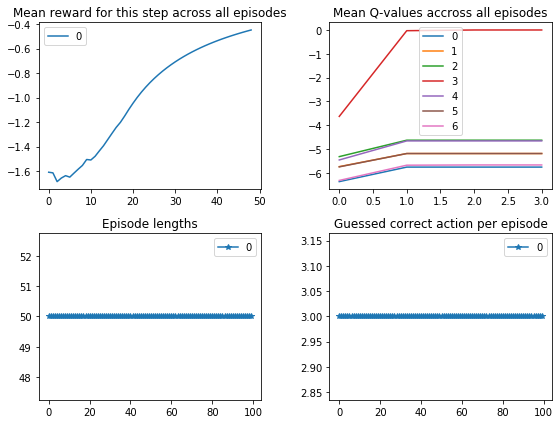

In [11]:
params = default_params()
params['noise'] = False
params['plots'] = True

# The Q-value shape make sense - we're trying higher numbers later
# so they converge to -1 slower than e.g. action 0 or 1
plot_mean_q_values()

# Noisy rewards
- rewards are now noisy
- q-learner hasn't changed

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

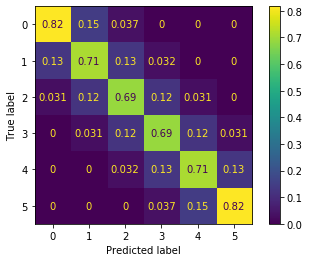

True

In [13]:
params = default_params()
num_actions = params['num_actions']
correct_action = params['correct_action']
# Confusion matrix used as noise
num_unique_rewards = utils.get_num_unique_rewards(num_actions=num_actions, correct_action=correct_action)
cmat = ModifiedPendulumProcessor(num_unique_rewards=num_unique_rewards).initialize_cmat(diag=0.69)
ConfusionMatrixDisplay(confusion_matrix=cmat).plot()
plt.show()
noise_estimator.is_invertible(cmat)

100%|██████████| 100/100 [00:00<00:00, 673.84it/s]


Accuracy: 83.0
Mean episode length: 50.49
Last reward processor:
Estimated confusion matrix:


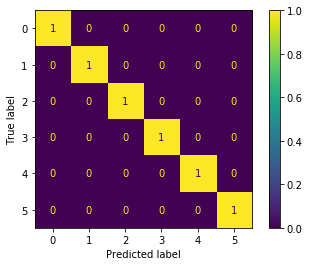

Reward sets:
{(0, 6): [-3, -4], (0, 4): [-2, -2, -3], (0, 0): [-2, -1], (0, 3): [-2, -2, -2], (0, 1): [0, 0, -1, 0, -1, 0, 0, 0, -1, 0, -1, 0, 0, -1, -2, 0, 0, 0, 0, 0, 0, -1, 0, -1, 0, -1, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0], (0, 2): [-2]}
Reward set counts:
Key (0, 6): 2 items
Key (0, 4): 3 items
Key (0, 0): 2 items
Key (0, 3): 3 items
Key (0, 1): 38 items
Key (0, 2): 1 items


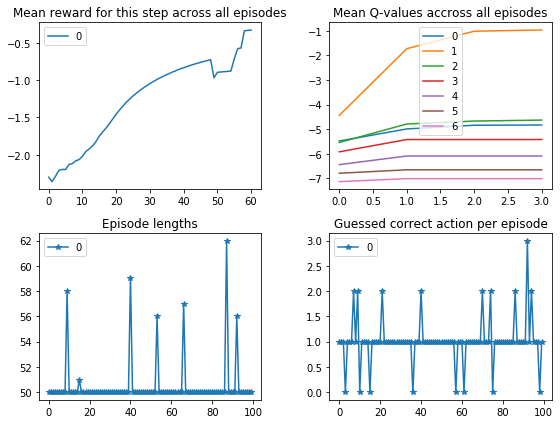

In [14]:
# res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
# params=res['params']
params = default_params()
params['plots'] = True
plot_mean_q_values(params=params)

# Surrogate rewards

100%|██████████| 100/100 [00:00<00:00, 697.24it/s]


Accuracy: 90.0
Mean episode length: 50.06
Last reward processor:
Estimated confusion matrix:


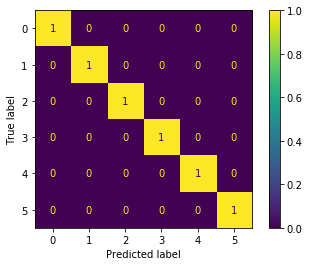

Reward sets:
{(0, 0): [-1], (0, 4): [-5, -4], (0, 1): [-1], (0, 2): [-2, 0, -1, -1, -1, 0, -2, -1, 0, -2, -1, -1, -1, -2, -2, 0, -1, -1, -1, -2, -2, -2, -1, -3, -1, -1, 0, -1, -2, 0, 0, -2, -2, -1, 0, -2, -2, -1], (0, 3): [-2, -2], (0, 5): [-4, -3], (0, 6): [-4, -3, -5]}
Reward set counts:
Key (0, 0): 1 items
Key (0, 4): 2 items
Key (0, 1): 1 items
Key (0, 2): 38 items
Key (0, 3): 2 items
Key (0, 5): 2 items
Key (0, 6): 3 items


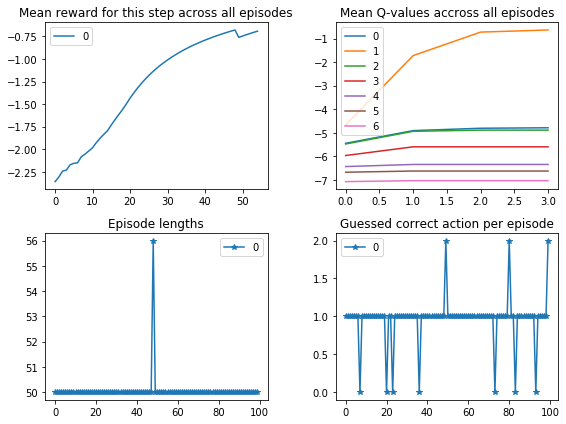

In [15]:
params_new ={'noise': True, 'surrogate': True, 'plots': True, 'surrogate_c_interval': 20}
params = default_params() | params
plot_mean_q_values(params = params)

# Sanity check

In [25]:
params = default_params()

print('Accuracy should be higher, timesteps should be lower')

params['noise'] = False
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = False
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

params['noise'] = True
params['surrogate'] = True
q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
mean_episode_length = np.mean(episode_lengths)
print(accuracy, mean_episode_length) 

Accuracy should be higher, timesteps should be lower


100%|██████████| 100/100 [00:00<00:00, 832.75it/s]


100.0 50.0


100%|██████████| 100/100 [00:00<00:00, 692.84it/s]


79.0 50.39


100%|██████████| 100/100 [00:00<00:00, 554.70it/s]

80.0 50.3


# Bayesian optimization

In [17]:
# | 24        | 100.0     | 0.9026    | 826.9     | 0.0       | 73.21     |
# this with noise True and surrogate False
# no alpha decay
# | 184       | 99.0      | 0.8236    | 243.1     | 0.5114    | 0.2529    | 70.53     | 0.04431   | 0.8871    | 67.76     |

In [18]:
from bayes_opt import BayesianOptimization

In [19]:
def objective(
        alpha,
        # alpha_decay,
        alpha_min,
        epsilon,
        epsilon_decay,
        epsilon_min,
        gamma,
        # surrogate_c_interval,
        ):
    # # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # # 'surrogate_lr'    
    # convergence_number_of_consequent_actions
    # intial_q_values: [0, -7]

    # surrogate_c_interval = int(surrogate_c_interval)

    new_params = {
        'alpha': alpha, 
        # 'alpha_decay': alpha_decay,
        'alpha_min': alpha_min,
        'epsilon': epsilon, 
        'epsilon_decay': epsilon_decay,
        'epsilon_min': epsilon_min,
        'gamma': gamma,
        # 'plots': False,   
        # 'surrogate_c_interval': surrogate_c_interval,
        #
        'noise': True,
        'surrogate': False,
        # 'diag': 0.9     
    }

    params = default_params() | new_params

    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy, _ = qLearningExperiment(params=params)
    


    # params['surrogate'] = False
    # q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy_no_surrogate, _ = qLearningExperiment(params=params)


    # accuracy = accuracy_surrogate - accuracy_no_surrogate
    
    # mean_episode_length = np.mean(episode_lengths)
    # return -mean_episode_length
    return accuracy

optimizer = BayesianOptimization(
    f=objective,
    pbounds={
        'alpha': (0, 1), 
        # 'alpha_decay': (1, 1000),
        'alpha_min': (0, 1),
        'epsilon': (0, 1), 
        'epsilon_decay': (10, 80),
        'epsilon_min': (0, 1),
        'gamma': (0, 1),
        # 'surrogate_c_interval': (1, 120)
        },
    random_state=1,
)

# n_iter: How many steps of bayesian optimization you want to perform. 
# The more steps the more likely to find a good maximum you are.
# init_points: How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.
optimizer.maximize(
    init_points=100,
    n_iter=100,
)

best_params = optimizer.max['params']

print(optimizer.max)

|   iter    |  target   |   alpha   | alpha_min |  epsilon  | epsilo... | epsilo... |   gamma   |
-------------------------------------------------------------------------------------------------


100%|██████████| 100/100 [00:00<00:00, 771.30it/s]


| 1         | 0.0       | 0.417     | 0.7203    | 0.0001144 | 31.16     | 0.1468    | 0.09234   |


100%|██████████| 100/100 [00:00<00:00, 326.34it/s]


| 2         | 33.0      | 0.1863    | 0.3456    | 0.3968    | 47.72     | 0.4192    | 0.6852    |


100%|██████████| 100/100 [00:00<00:00, 801.23it/s]


| 3         | 3.0       | 0.2045    | 0.8781    | 0.02739   | 56.93     | 0.4173    | 0.5587    |


100%|██████████| 100/100 [00:00<00:00, 361.51it/s]


| 4         | 51.0      | 0.1404    | 0.1981    | 0.8007    | 77.78     | 0.3134    | 0.6923    |


100%|██████████| 100/100 [00:00<00:00, 601.40it/s]


| 5         | 94.0      | 0.8764    | 0.8946    | 0.08504   | 12.73     | 0.1698    | 0.8781    |


100%|██████████| 100/100 [00:00<00:00, 345.36it/s]


| 6         | 20.0      | 0.09835   | 0.4211    | 0.9579    | 47.32     | 0.6919    | 0.3155    |


100%|██████████| 100/100 [00:00<00:00, 794.89it/s]


| 7         | 57.0      | 0.6865    | 0.8346    | 0.01829   | 62.51     | 0.9889    | 0.7482    |


100%|██████████| 100/100 [00:00<00:00, 603.21it/s]


| 8         | 3.0       | 0.2804    | 0.7893    | 0.1032    | 41.35     | 0.9086    | 0.2936    |


100%|██████████| 100/100 [00:00<00:00, 816.08it/s]


| 9         | 1.0       | 0.2878    | 0.13      | 0.01937   | 57.52     | 0.2116    | 0.2655    |


100%|██████████| 100/100 [00:00<00:00, 345.65it/s]


| 10        | 55.0      | 0.4916    | 0.05336   | 0.5741    | 20.27     | 0.5893    | 0.6998    |


100%|██████████| 100/100 [00:00<00:00, 719.43it/s]


| 11        | 27.0      | 0.1023    | 0.4141    | 0.6944    | 38.99     | 0.04995   | 0.5359    |


100%|██████████| 100/100 [00:00<00:00, 346.00it/s]


| 12        | 63.0      | 0.6638    | 0.5149    | 0.9446    | 51.06     | 0.9034    | 0.1375    |


100%|██████████| 100/100 [00:00<00:00, 351.53it/s]


| 13        | 16.0      | 0.1393    | 0.8074    | 0.3977    | 21.57     | 0.9275    | 0.3478    |


100%|██████████| 100/100 [00:00<00:00, 317.46it/s]


| 14        | 61.0      | 0.7508    | 0.726     | 0.8833    | 53.66     | 0.7509    | 0.3489    |


100%|██████████| 100/100 [00:00<00:00, 337.91it/s]


| 15        | 19.0      | 0.2699    | 0.8959    | 0.4281    | 77.54     | 0.6634    | 0.6217    |


100%|██████████| 100/100 [00:00<00:00, 354.98it/s]


| 16        | 11.0      | 0.1147    | 0.9495    | 0.4499    | 50.49     | 0.4081    | 0.237     |


100%|██████████| 100/100 [00:00<00:00, 850.48it/s]


| 17        | 16.0      | 0.9034    | 0.5737    | 0.00287   | 53.2      | 0.3266    | 0.5271    |


100%|██████████| 100/100 [00:00<00:00, 689.63it/s]


| 18        | 95.0      | 0.8859    | 0.3573    | 0.9085    | 53.64     | 0.01582   | 0.9294    |


100%|██████████| 100/100 [00:00<00:00, 417.70it/s]


| 19        | 79.0      | 0.6909    | 0.9973    | 0.1723    | 19.6      | 0.9326    | 0.6968    |


100%|██████████| 100/100 [00:00<00:00, 331.08it/s]


| 20        | 20.0      | 0.066     | 0.7555    | 0.7539    | 74.61     | 0.7115    | 0.1243    |


100%|██████████| 100/100 [00:00<00:00, 755.88it/s]


| 21        | 10.0      | 0.01988   | 0.02621   | 0.02831   | 27.23     | 0.86      | 0.5388    |


100%|██████████| 100/100 [00:00<00:00, 532.14it/s]


| 22        | 93.0      | 0.5528    | 0.842     | 0.1242    | 29.54     | 0.5858    | 0.9696    |


100%|██████████| 100/100 [00:00<00:00, 336.23it/s]


| 23        | 62.0      | 0.561     | 0.01865   | 0.8006    | 26.31     | 0.8071    | 0.3879    |


100%|██████████| 100/100 [00:00<00:00, 567.58it/s]


| 24        | 58.0      | 0.8635    | 0.7471    | 0.5562    | 19.55     | 0.05992   | 0.1213    |


100%|██████████| 100/100 [00:00<00:00, 384.06it/s]


| 25        | 6.0       | 0.04455   | 0.1075    | 0.2257    | 59.91     | 0.5597    | 0.01256   |


100%|██████████| 100/100 [00:00<00:00, 409.00it/s]


| 26        | 40.0      | 0.07197   | 0.9673    | 0.5681    | 24.23     | 0.2523    | 0.7438    |


100%|██████████| 100/100 [00:00<00:00, 369.81it/s]


| 27        | 41.0      | 0.1954    | 0.5814    | 0.97      | 69.28     | 0.2398    | 0.4938    |


100%|██████████| 100/100 [00:00<00:00, 746.20it/s]


| 28        | 22.0      | 0.62      | 0.829     | 0.1568    | 11.3      | 0.07002   | 0.4863    |


100%|██████████| 100/100 [00:00<00:00, 352.98it/s]


| 29        | 53.0      | 0.6063    | 0.5689    | 0.3174    | 79.2      | 0.5797    | 0.3801    |


100%|██████████| 100/100 [00:00<00:00, 605.77it/s]


| 30        | 59.0      | 0.5509    | 0.7453    | 0.6692    | 28.54     | 0.06633   | 0.3701    |


100%|██████████| 100/100 [00:00<00:00, 338.27it/s]


| 31        | 74.0      | 0.6297    | 0.2102    | 0.7528    | 14.66     | 0.2603    | 0.8048    |


100%|██████████| 100/100 [00:00<00:00, 360.44it/s]


| 32        | 30.0      | 0.1934    | 0.6395    | 0.5247    | 74.74     | 0.2633    | 0.06596   |


100%|██████████| 100/100 [00:00<00:00, 487.57it/s]


| 33        | 73.0      | 0.7351    | 0.7722    | 0.9078    | 75.24     | 0.01395   | 0.2344    |


100%|██████████| 100/100 [00:00<00:00, 325.78it/s]


| 34        | 53.0      | 0.6168    | 0.949     | 0.9502    | 48.97     | 0.9156    | 0.6416    |


 65%|██████▌   | 65/100 [00:00<00:00, 315.09it/s]


KeyboardInterrupt: 

100%|██████████| 1000/1000 [00:01<00:00, 585.25it/s]


Accuracy: 96.6
Mean episode length: 56.629
Last reward processor:
Estimated confusion matrix:


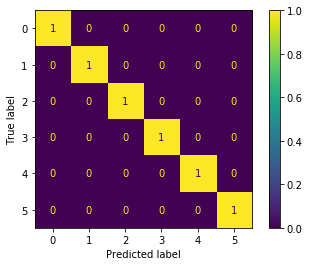

Reward sets:
{(0, 0): [-1, -1], (0, 1): [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, -1, -1, 0, 0, 0, -1, -1, 0, 0, 0, 0], (0, 2): [-1], (0, 3): [-3, -3], (0, 5): [-3], (0, 4): [-3, -3], (0, 6): [-4]}
Reward set counts:
Key (0, 0): 2 items
Key (0, 1): 40 items
Key (0, 2): 1 items
Key (0, 3): 2 items
Key (0, 5): 1 items
Key (0, 4): 2 items
Key (0, 6): 1 items


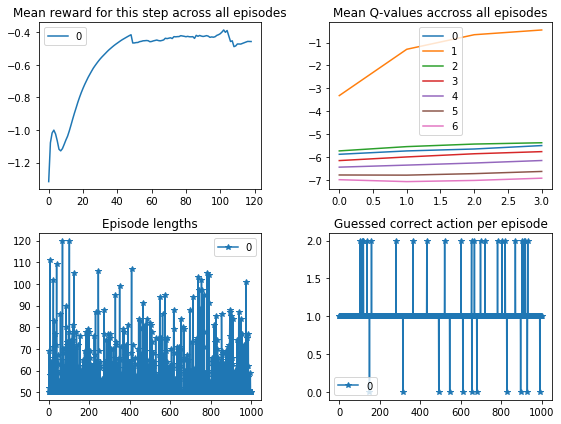

100%|██████████| 1000/1000 [00:01<00:00, 622.61it/s]


Accuracy: 96.1
Mean episode length: 56.648
Last reward processor:
Estimated confusion matrix:


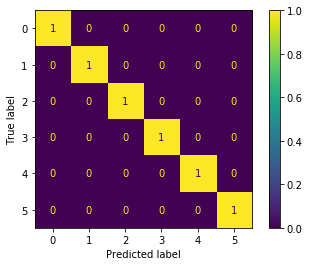

Reward sets:
{(0, 2): [-1], (0, 0): [-1], (0, 1): [0, -1, -1, 0, 0, 0, 0, -2, -1, -1, -1, -1, 0, 0, -2, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, -1, -2, 0, 0, 0, -1, 0, 0, -2, 0, 0, -2, 0, -2, -2, -1, -1], (0, 3): [-2], (0, 6): [-5, -4]}
Reward set counts:
Key (0, 2): 1 items
Key (0, 0): 1 items
Key (0, 1): 44 items
Key (0, 3): 1 items
Key (0, 6): 2 items


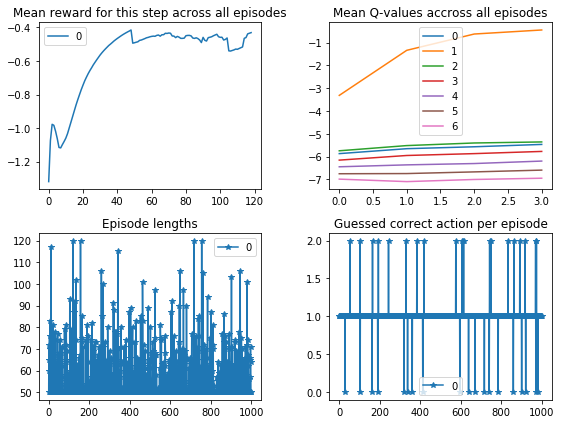

In [53]:
res = {'target': 95.89999999999999, 'params': {'alpha': 0.8236118040381998, 'alpha_decay': 243.0544785033269, 'alpha_min': 0.5113965695937486, 'epsilon': 0.25289603267158034, 'epsilon_decay': 70.53090930872196, 'epsilon_min': 0.044310479986752194, 'gamma': 0.8871072251030447, 'surrogate_c_interval': 67.76179038423699}}
params=res['params']

params['noise'] = True
params['surrogate'] = False
plot_mean_q_values(params=params)

params['surrogate'] = True
plot_mean_q_values(params=params)

# TODO

In [22]:
import numpy as np
from bayes_opt import BayesianOptimization
from pymoo.optimize import minimize
from pymoo.util import plotting
from pymoo.model.problem import Problem

max_steps = 120
num_episodes = 100

class QLearningProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=np.array([0, 0, 10]), xu=np.array([1, 1, 80]))
    
    def _evaluate(self, X, out, *args, **kwargs):
        alpha, epsilon, epsilon_decay = X

        # Run your Q-learning experiment with given parameters
        params = {'alpha': alpha, 'epsilon': epsilon, 'epsilon_decay': epsilon_decay}
        q_values_all_experiments, _, episode_lengths, _, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)

        # Maximize accuracy
        out["F"] = [-accuracy, -np.mean(episode_lengths)]

problem = QLearningProblem()

algorithm = minimize(
    algorithm="nsga2",
    problem=problem,
    termination=("n_gen", 20),  # Adjust the number of generations as needed
    save_history=True,
    verbose=True,
)

# Get the best solution from the Pareto front
best_solution = algorithm.result[0]

best_alpha, best_epsilon, best_epsilon_decay = best_solution.X

print(f"Best alpha: {best_alpha}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best epsilon_decay: {best_epsilon_decay}")
print(f"Best accuracy: {-best_solution.F[0]}")
print(f"Best mean_episode_length: {-best_solution.F[1]}")

# You can visualize the Pareto front using pymoo's plotting functions
plotting.plot(obj_space=algorithm.result.F, ideal_point=np.array([0, 0]), title="Pareto Front")


ModuleNotFoundError: No module named 'pymoo'

# Grid search

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
from IPython import display
import pandas as pd

In [ ]:
max_steps = 120
num_episodes = 20

param_grid = {
    'alpha': [0, 1.0],
    # 'alpha_decay'
    # alpha_min
    'epsilon': [0, 1.0],
    # 'epsilon_decay': [0.1, 1.0],
    # 'gamma'
    'epsilon_decay': [10, 20, 40, 80],
    # 'surrogate_c_interval': [1, 2, 5, 10, 20, 40]
    # 'surrogate_lr'
    }

param_grid_out = pd.DataFrame(ParameterGrid(param_grid))

def get_results_from_grid_row(params):
    q_values_all_experiments, rewards_all_experiments, episode_lengths, selected_actions, accuracy = qLearningExperiment(adjust_rewards_surrogate, params=params)
    mean_episode_length = np.mean(episode_lengths)
    print(accuracy, mean_episode_length) 

    return accuracy, mean_episode_length

for i, params in tqdm(param_grid_out.iterrows(), total=param_grid_out.shape[0]):
    accuracy, mean_episode_length = get_results_from_grid_row(params)
    param_grid_out.loc[i, 'accuracy'] = accuracy
    param_grid_out.loc[i, 'mean_episode_length'] = mean_episode_length
    # display.clear_output()

  6%|▋         | 1/16 [00:11<02:47, 11.14s/it]

0.0 121.0


  6%|▋         | 1/16 [00:22<05:40, 22.68s/it]


KeyboardInterrupt: 

In [ ]:
# param_grid_out.iloc[0]['accuracy'] = 1
print(param_grid_out.sort_values(by=['accuracy', 'mean_episode_length'], ascending=False))

    alpha  epsilon  epsilon_decay  accuracy  mean_episode_length
1     0.1      0.1             20      95.0                73.70
7     0.1      1.0             80      90.0                82.70
15    1.0      1.0             80      85.0                91.00
4     0.1      1.0             10      85.0                83.35
10    1.0      0.1             40      85.0                78.55
5     0.1      1.0             20      85.0                75.75
12    1.0      1.0             10      80.0                80.90
6     0.1      1.0             40      75.0                78.45
11    1.0      0.1             80      75.0                78.45
14    1.0      1.0             40      75.0                77.20
8     1.0      0.1             10      75.0                74.95
2     0.1      0.1             40      70.0                87.90
13    1.0      1.0             20      70.0                82.85
3     0.1      0.1             80      65.0                82.65
0     0.1      0.1       

# Epsilon test

In [21]:
np.log10(20+1)

1.3222192947339193

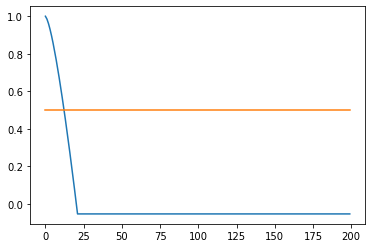

In [28]:
agent = UCBQAgent()
epsilons = []
for t in range(200):
    epsilons.append(agent.epsilon)
    agent.choose_action(0)

plt.plot(epsilons)

agent = UCBQAgent()
alphas = []
for t in range(200):
    alphas.append(agent.alpha)
    agent.choose_action(0)

plt.plot(alphas)

# Surrogate rewards without adding noise

In [25]:
from modified_pendulum_processor_noiseless import ModifiedPendulumProcessorNoiseless

In [26]:
post_processor_surrogate = ModifiedPendulumProcessorNoiseless()

def adjust_rewards_surrogate(reward, state, action):    
    observation, reward, done, info = post_processor_surrogate.process_step(state, reward, None, None, action)
    return reward

plot_mean_q_values(adjust_rewards_surrogate)

print(post_processor_surrogate.cmat)
print(post_processor_surrogate.r_sets)
print('Estimated confusion matrix:')
print(np.around(post_processor_surrogate.C, decimals=4))

TypeError: 'NoneType' object cannot be interpreted as an integer